#Analysis for the race

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import torch

from tqdm import tqdm
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count


#
from train.model import ResNet
from train.prediction import validate
from analysis.plot import plot_roc_simple
from analysis.tools import from_loader_to_tensor

datadir = 'datafiles'
dataset_pth = datadir + '/NIH_part/'
metadata_csv ='./datafiles/NIH_train_val_test_rs0_f50.csv'
metadata = pd.read_csv(metadata_csv)

### Basic statistics

We can also take a look at the distribution of some sensitive attributes:

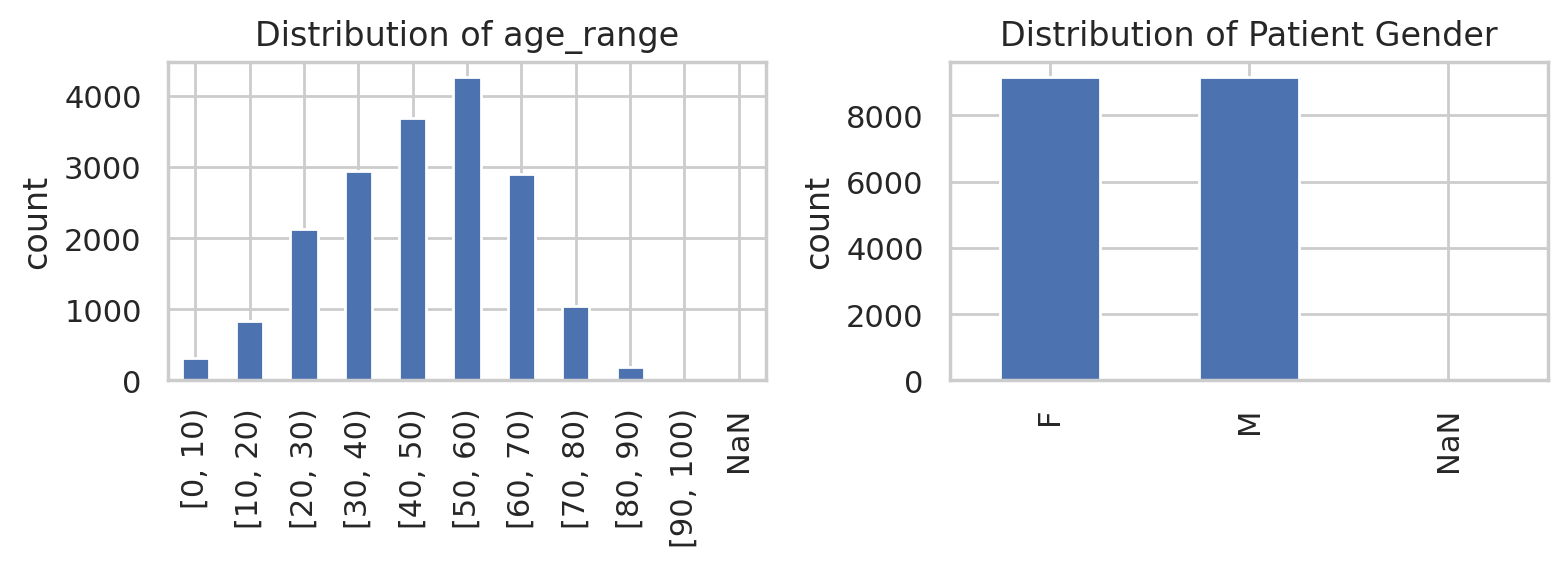

In [4]:
def plot_distribution_by_value(metadata, column_name):
    if isinstance(column_name, str):
        nan_count = metadata[column_name].isna().sum()
        nan_series = pd.Series([nan_count], index=['NaN'])
        counts_ = metadata[column_name].value_counts().sort_index()
        counts_with_nan = pd.concat([counts_, nan_series])

        counts_with_nan.plot(kind='bar',title='Distribution of {}'.format(column_name))
        plt.ylabel('count')
    elif isinstance(column_name, list):
        fig, axes = plt.subplots( 1, len(column_name), figsize=( len(column_name)*4,3),dpi=200)
        for i,col in enumerate(column_name):
            nan_count = metadata[col].isna().sum()
            nan_series = pd.Series([nan_count], index=['NaN'])
            counts_ = metadata[col].value_counts().sort_index()
            counts_with_nan = pd.concat([counts_, nan_series])

            counts_with_nan.plot(kind='bar',title='Distribution of {}'.format(col),ax=axes[i])
            axes[i].set_ylabel('count')
    plt.tight_layout()
    plt.show()
metadata['age_range'] = pd.cut(metadata['Patient Age'], bins=[0,10,20,30,40,50,60,70,80,90,100], right=False)
plot_distribution_by_value(metadata, ['age_range','Patient Gender'])

In [ ]:
metadata.columns

# Loading model

In [75]:
# load the pretrained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(' device:', device)

ds_name = 'NIH'

# load the model
lr=1e-6
pretrained = True
model_scale = '18'
num_epochs =20
img_size = (1, 224, 224)

classifier = ResNet(num_classes=1, lr=lr, pretrained=pretrained, model_scale=model_scale, in_channel=img_size[0])
# classifier.load_state_dict(torch.load('./pretrained_model/nih_pneumothorax.pth'))

# use cpu
classifier.load_state_dict(torch.load('./pretrained_model/nih_pneumothorax.pth', map_location=torch.device('cpu')))

classifier.to(device)

classifier.eval()


 device: cuda


/zhome/21/8/202236/miniconda3/envs/rai_fairness/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/zhome/21/8/202236/miniconda3/envs/rai_fairness/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

### Load test and validation data

In [76]:
save_model_at = './pretrained_models/'

img_size = (1,224,224)
batch_size = 16

csv_pth = './datafiles/NIH_train_val_test_rs0_f50.csv' if ds_name == 'NIH' else None

disease_label = 'Pneumothorax' 
sensitive_label = 'sex'
augmentation = False

from train.train_chestxray import create_datasets

train_dataset, val_dataset, test_dataset = create_datasets(dataset_pth, 
                                                               ds_name,
                                                               csv_pth, 
                                                               image_size=img_size, 
                                                               device=device,
                                                               disease_label = disease_label,
                                                               sensitive_label = sensitive_label,
                                                               augmentation=augmentation)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # we dont need it here
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Loading Data: 100%|██████████| 8459/8459 [00:00<00:00, 22523.71it/s]


### Predict the results for test set

In [77]:
test_lab, test_pred, test_prob, test_a= validate(classifier, test_loader, device=device)

100%|██████████| 529/529 [00:35<00:00, 15.01it/s]

val_loss=1.2348 val_acc=0.8094 val_auroc=0.7726


Farness metrics

In [78]:

metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,
           'false_positive_rate': false_positive_rate,
           'true_positive_rate': true_positive_rate,
           'false_negative_rate': false_negative_rate,
           'true_negative_rate': true_negative_rate,
}

array([[<Axes: title={'center': 'accuracy'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'true_positive_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'true_negative_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'count'}, xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>]], dtype=object)

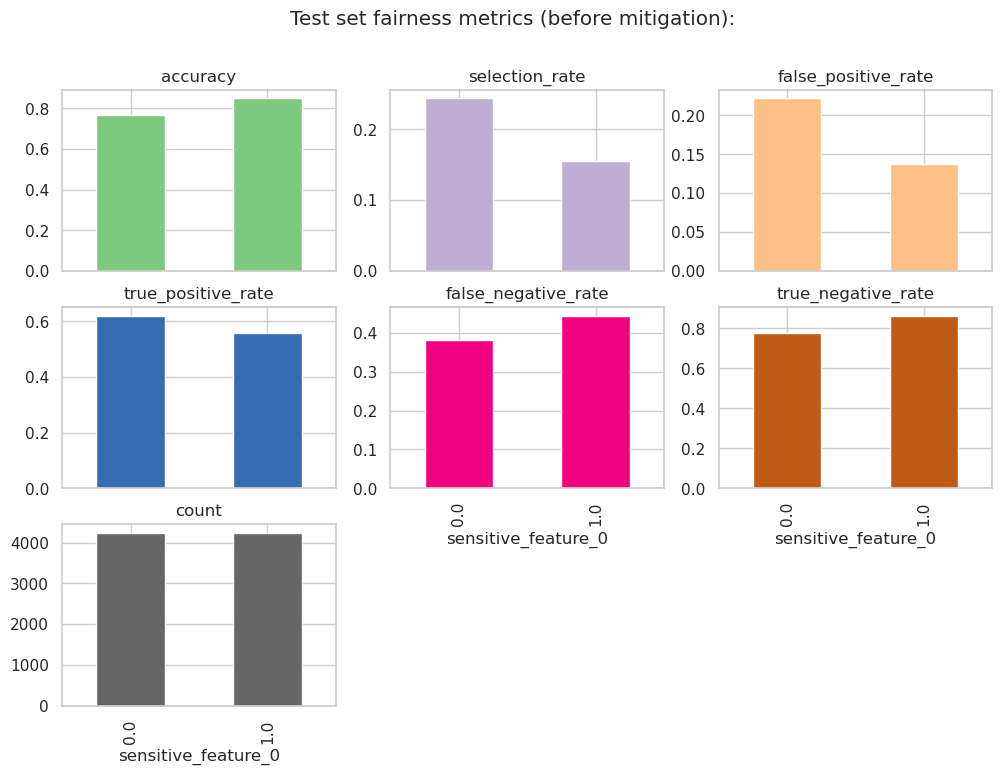

In [79]:
mf_original = MetricFrame(metrics=metrics,
                 y_true=test_lab,
                 y_pred=test_pred,
                 sensitive_features=test_a)

mf_original.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Test set fairness metrics (before mitigation):",
)

In [80]:
df_before_mitigation= mf_original.by_group
print(f'df_before_mitigation:')
df_before_mitigation

df_before_mitigation:


,accuracy,selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
sensitive_feature_0,,,,,,,
0.0,0.769213,0.244029,0.222028,0.619658,0.380342,0.777972,4229.0
1.0,0.849645,0.155083,0.137463,0.556180,0.443820,0.862537,4230.0


### Draw the ROC curve

Here we provide the funtion `plot_roc_simple` to draw the ROC curve for each groups.

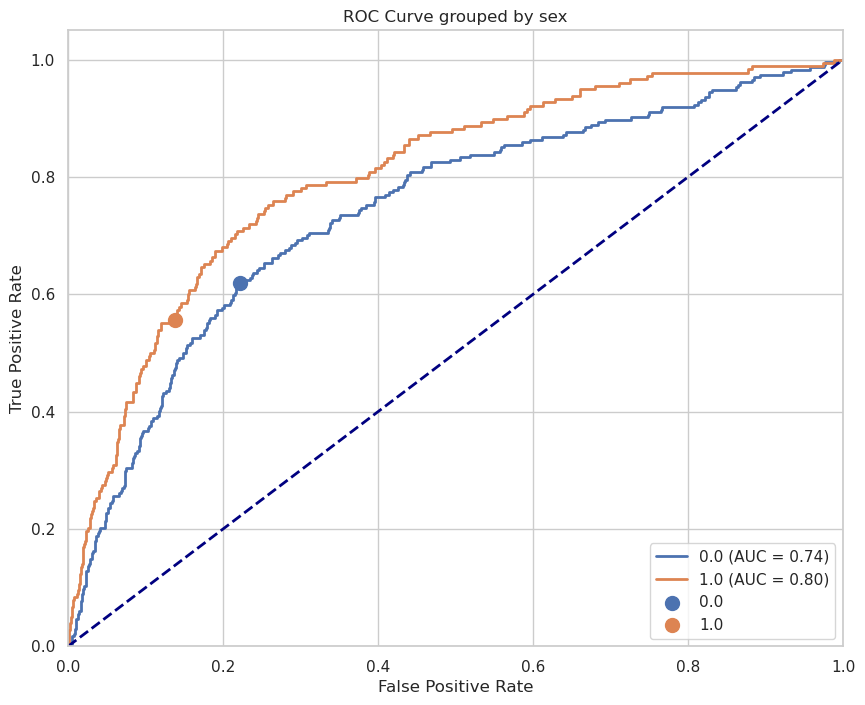

In [81]:
plot_roc_simple(test_lab, test_prob, test_a, test_pred,
        sensitive_attribute_name ='sex',
        )

In [82]:
from sklearn.base import BaseEstimator, ClassifierMixin

class FakeClassifierInput2D(BaseEstimator,ClassifierMixin):
    '''
    Fake classifier that takes 2D input, with pre-trained model that does not take 2D input data
    '''
    def __init__(self,model, img_size):
        self.model = model
        self.img_size = img_size
        self.input_from_2D_func = lambda x: torch.reshape(x,(-1,)+self.img_size)
        # self.input_from_2D_func = input_from_2D_func
        self.fit_ = True # fake the check_fit function inside the fairlearn library

    def fit(self, X, y):
        # Do not need to fit
        # self.is_fitted_ = True  # This ensures check_is_fitted works
        return

    def predict(self, X_2D, ):
        assert len(X_2D.shape) == 2
        X = self.input_from_2D_func(X_2D)
        return self.model.predict(X)
    
    def predict_proba(self, X_2D):
        X = self.input_from_2D_func(X_2D)
        return self.model.predict_proba(X)
    


### ------------Optimize on validation set--------------------------

In [83]:
X_test, y_test, a_test = from_loader_to_tensor(test_loader,device)
X_val, y_val, a_val = from_loader_to_tensor(val_loader,device)

X_test_2D = torch.reshape(X_test,(X_test.shape[0],-1))
X_val_2D = torch.reshape(X_val,(X_val.shape[0],-1))
print(X_test_2D.shape)

100%|██████████| 529/529 [00:19<00:00, 27.76it/s]


X.shape=torch.Size([8459, 1, 224, 224]), y.shape=torch.Size([8459]), a.shape=torch.Size([8459])


100%|██████████| 89/89 [00:03<00:00, 22.29it/s]


X.shape=torch.Size([1409, 1, 224, 224]), y.shape=torch.Size([1409]), a.shape=torch.Size([1409])
torch.Size([8459, 50176])


In [84]:
classifier_fake = FakeClassifierInput2D(model=classifier.to('cpu'), img_size = img_size)

Your code here:

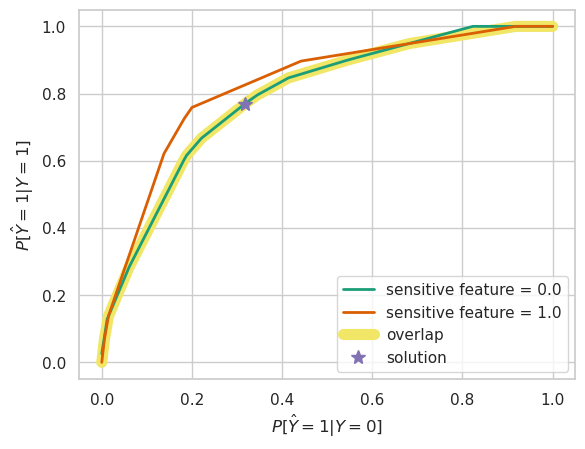

In [85]:
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.postprocessing import plot_threshold_optimizer

# define ThresholdOptimizer
threshold_opt = ThresholdOptimizer(
    estimator=classifier_fake,
    constraints='equalized_odds', # TPR,FPR
    objective='balanced_accuracy_score',  
    predict_method='predict_proba',
)
# fit ThresholdOptimizer
threshold_opt.fit(X_val_2D, y_val, sensitive_features=a_val)

plot_threshold_optimizer(threshold_opt, ax=None, show_plot=True)

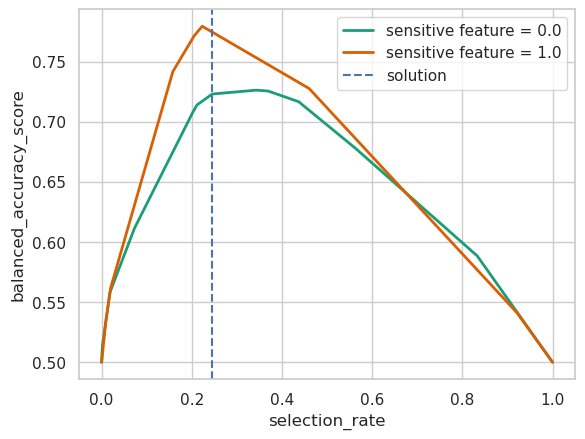

In [86]:
"""
This part we define a new Threshold Optimizer with Independence as constraint.
"""
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.postprocessing import plot_threshold_optimizer
# define Threshold Opt ---constraints with Independence
to_demograph = ThresholdOptimizer(
    estimator=classifier_fake,
    constraints='demographic_parity', # Independence
    objective='balanced_accuracy_score',  
    predict_method='predict_proba',
)

# fit ThresholdOptimizer
# to_demograph.fit(X_test_2D, y_test, sensitive_features=a_test)
to_demograph.fit(X_val_2D, y_val, sensitive_features=a_val)

# plot_threshold_optimizer
plot_threshold_optimizer(to_demograph, ax=None, show_plot=True)

### Use the new threshold for the test set

Your code here:

/zhome/21/8/202236/miniconda3/envs/rai_fairness/lib/python3.9/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1. 0. 0. ... 0. 0. 0.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


array([[<Axes: title={'center': 'accuracy'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'true_positive_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'true_negative_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'count'}, xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>]], dtype=object)

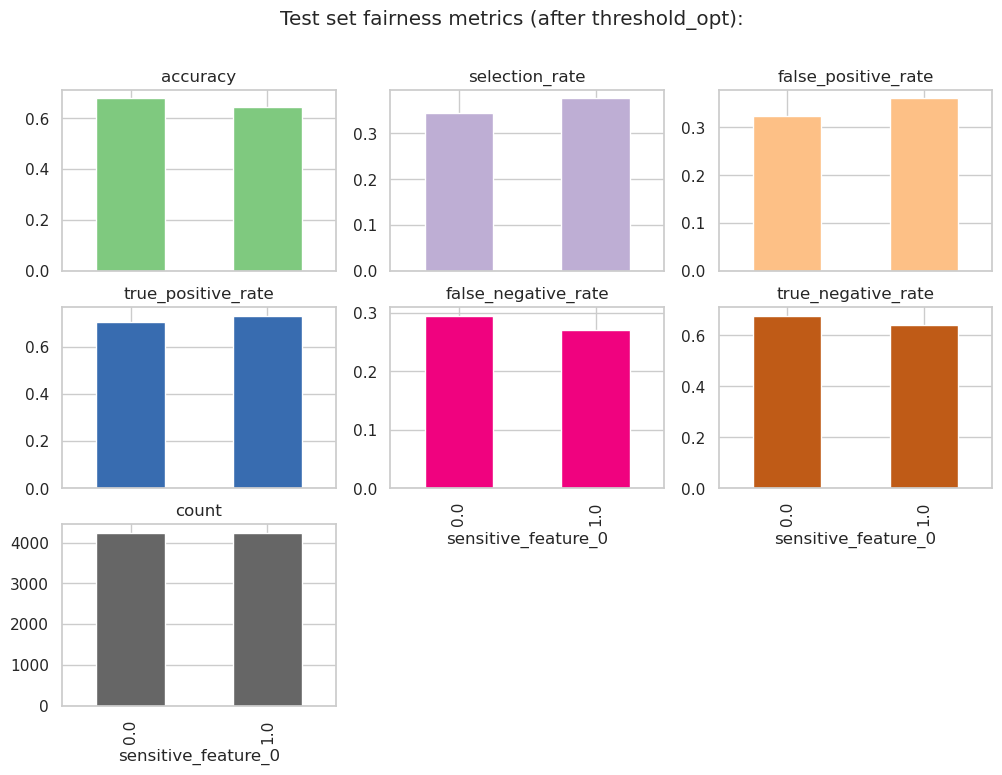

In [87]:
y_pre_fair_test = threshold_opt.predict(X_test_2D, sensitive_features=a_test)

mf = MetricFrame(metrics=metrics,
                 y_true=test_lab,
                 y_pred=y_pre_fair_test,
                 sensitive_features=test_a)

# print("Test set fairness metrics (after mitigation):")
# mf.by_group

mf.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Test set fairness metrics (after threshold_opt):",
)


In [88]:
df_to_equalized_odds = mf.by_group
print(f'df_to_equalized_odds:')
df_to_equalized_odds

df_to_equalized_odds:


,accuracy,selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
sensitive_feature_0,,,,,,,
0.0,0.678175,0.344526,0.323404,0.705128,0.294872,0.676596,4229.0
1.0,0.642790,0.376596,0.361056,0.730337,0.269663,0.638944,4230.0


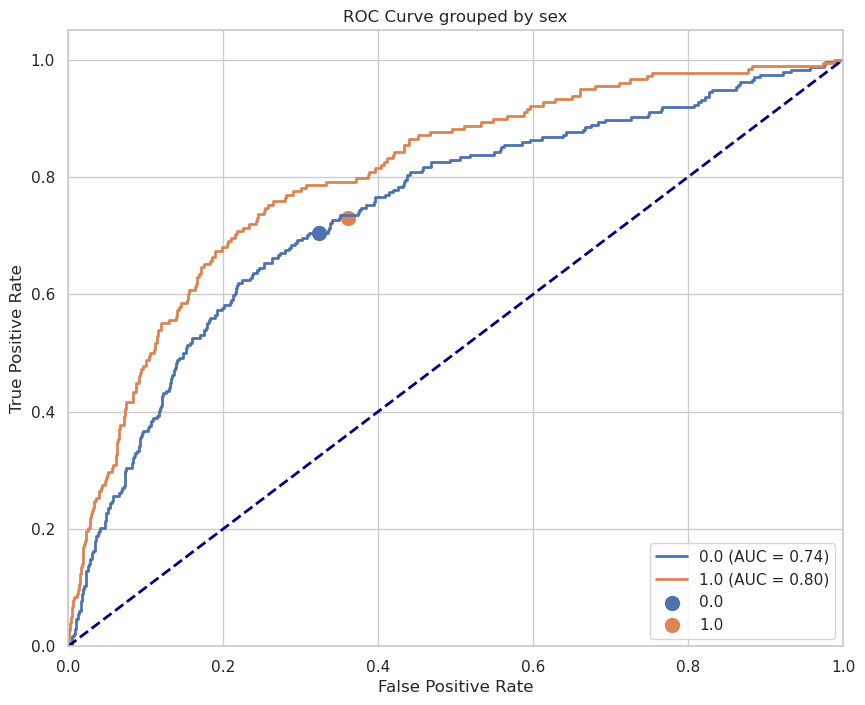

In [89]:
plot_roc_simple(test_lab, test_prob, test_a, y_pre_fair_test,
        sensitive_attribute_name = 'sex',
        )

/zhome/21/8/202236/miniconda3/envs/rai_fairness/lib/python3.9/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1. 0. 0. ... 0. 0. 0.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


array([[<Axes: title={'center': 'accuracy'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'true_positive_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'true_negative_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'count'}, xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>]], dtype=object)

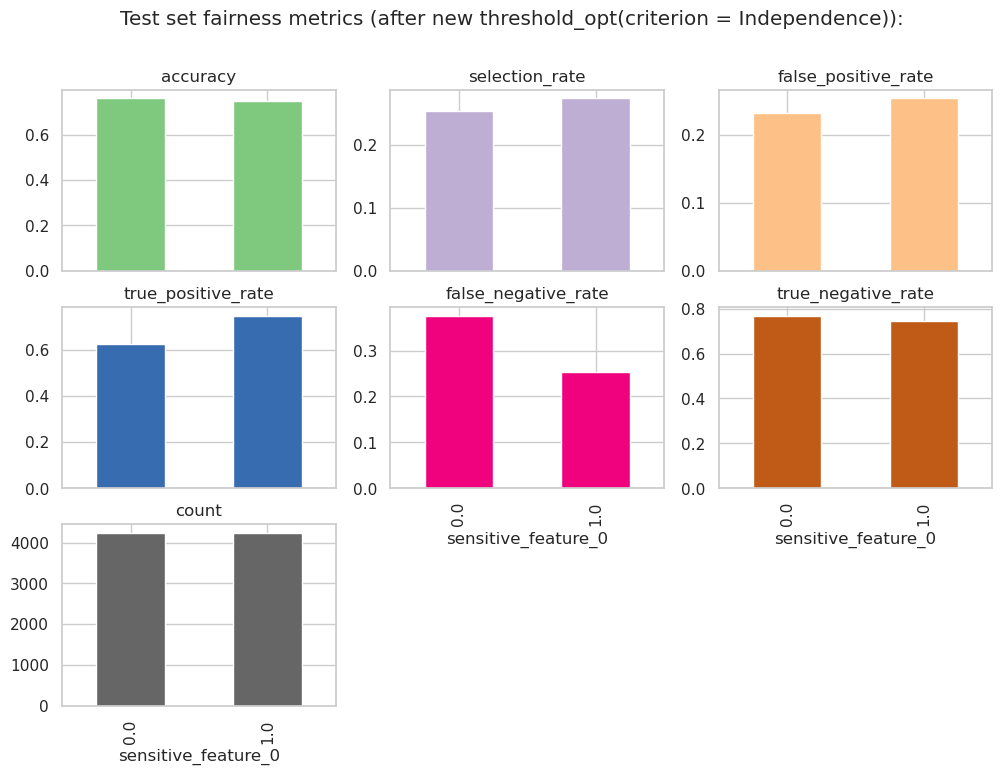

In [90]:
"""
This part we use the new Threshold Optimizer(constraint = 'demographic_parity' -> criterion = Independence) for the test set.
"""
y_pred_new_threshold_opt = to_demograph.predict(X_test_2D, sensitive_features=a_test)

mf_new_threshold_opt = MetricFrame(metrics=metrics,
                 y_true=test_lab,
                 y_pred=y_pred_new_threshold_opt,
                 sensitive_features=test_a)

mf_new_threshold_opt.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Test set fairness metrics (after new threshold_opt(criterion = Independence)):",
)


In [91]:
df_to_independence = mf_new_threshold_opt.by_group
print(f'df_to_independence:')
df_to_independence

df_to_independence:


,accuracy,selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
sensitive_feature_0,,,,,,,
0.0,0.760463,0.253251,0.231539,0.623932,0.376068,0.768461,4229.0
1.0,0.746809,0.273995,0.253208,0.747191,0.252809,0.746792,4230.0


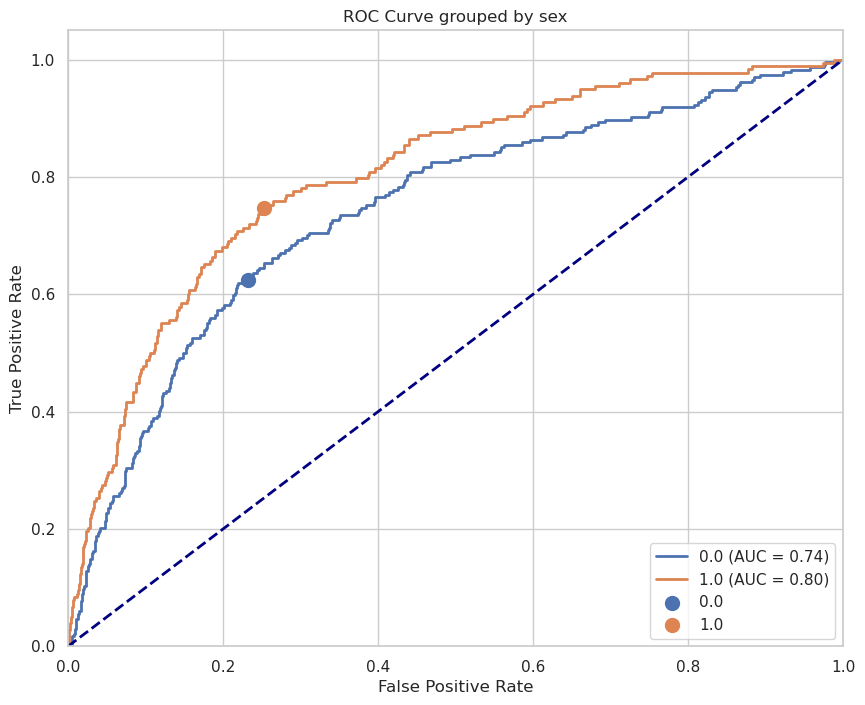

In [92]:
"""
This part we use the new Threshold Optimizer(constraint = 'demographic_parity' -> criterion = Independence) for the test set.
"""
plot_roc_simple(test_lab, test_prob, test_a, y_pred_new_threshold_opt,
        sensitive_attribute_name = 'sex',
        )

### To find out how the prediction come from (the new threshold $T_a$)

In [93]:
import json
threshold_rules_by_group = threshold_opt.interpolated_thresholder_.interpolation_dict
print(json.dumps(threshold_rules_by_group, default=str, indent=4))

{
    "0.0": {
        "p_ignore": 0.0,
        "prediction_constant": 0.317,
        "p0": 0.9932222222222229,
        "operation0": "[>0.30685362219810486]",
        "p1": 0.006777777777777105,
        "operation1": "[>0.2707938849925995]"
    },
    "1.0": {
        "p_ignore": 0.11022723354625812,
        "prediction_constant": 0.317,
        "p0": 0.5154907975460122,
        "operation0": "[>0.24994363635778427]",
        "p1": 0.48450920245398776,
        "operation1": "[>0.06453405320644379]"
    }
}


In [94]:
import numpy as np
# create a new set of distorted target labels
distorted_labels_test = y_test.clone()

# Get indices of male individuals (a_test == 1) with healthy labels (distorted_labels_test == 0)
male_indices_test = (a_test == 1) & (distorted_labels_test == 0)
print(f'a_test == 1.shape={np.where(a_test == 1)[0].shape}')
print(f'a_test.shape={a_test.shape}')
print(f'distorted_labels_test == 0.shape={np.where(distorted_labels_test==0)[0].shape}')
print(f'y_test.shape={y_test.shape}')
print(f'male_indices_test.shape={male_indices_test.shape}')
male_healthy_indices_test = np.where(male_indices_test)[0]
print(f'male_healthy_indices_test.shape ={male_healthy_indices_test.shape}')

a_test == 1.shape=(4230,)
a_test.shape=torch.Size([8459])
distorted_labels_test == 0.shape=(8047,)
y_test.shape=torch.Size([8459])
male_indices_test.shape=torch.Size([8459])
male_healthy_indices_test.shape =(4052,)


In [95]:
# Determine the number of labels to flip (30% of healthy male labels)
num_to_flip_test = int(0.3 * len(male_healthy_indices_test))

# Randomly select indices to flip
np.random.seed(42)  # For reproducibility
indices_to_flip_test = np.random.choice(male_healthy_indices_test, size=num_to_flip_test, replace=False)

# Flip the selected labels to diseased (label == 1)
distorted_labels_test[indices_to_flip_test] = 1

# Verify the changes
print(f"Original healthy male labels: {len(male_healthy_indices_test)}")
print(f"Number of labels flipped: {num_to_flip_test}")

Original healthy male labels: 4052
Number of labels flipped: 1215


In [96]:
# # re-fit ThresholdOptimizer(criterion = equalized_odds)
# threshold_opt.fit(X_test_2D, distorted_labels_test, sensitive_features=a_test)
# # plot
# plot_threshold_optimizer(threshold_opt, ax=None, show_plot=True)

In [97]:
# y_distorted_pre_fair_test = threshold_opt.predict(X_test_2D, sensitive_features=a_test)

array([[<Axes: title={'center': 'accuracy'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'true_positive_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'true_negative_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'count'}, xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>]], dtype=object)

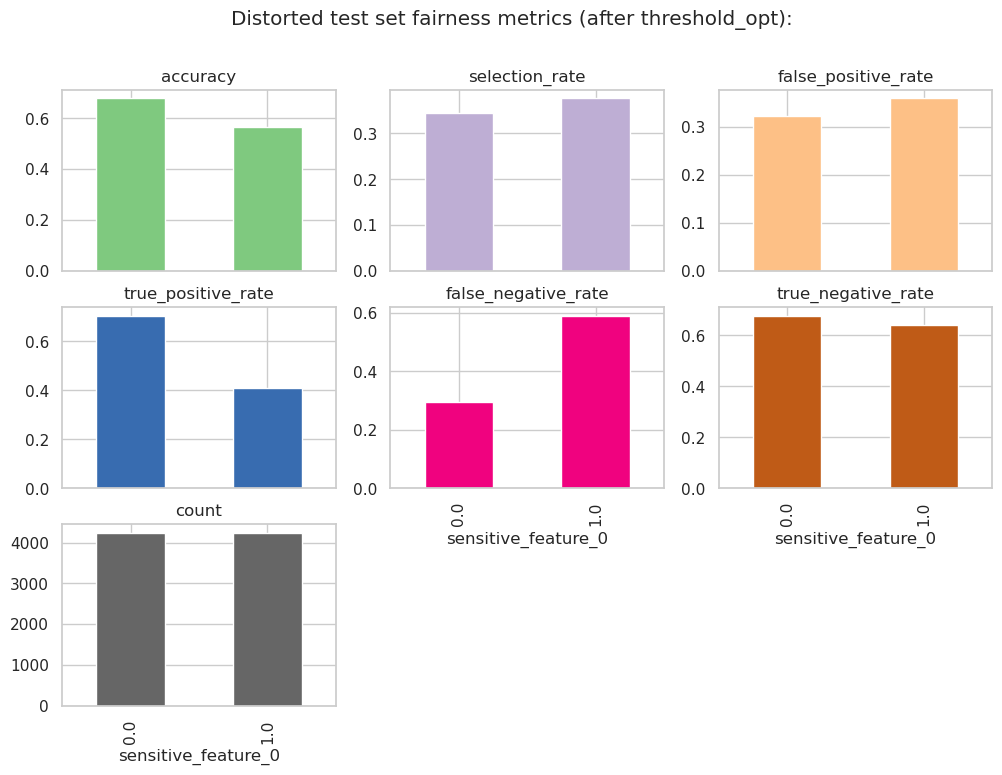

In [98]:
mf = MetricFrame(metrics=metrics,
                 y_true=distorted_labels_test,
                 y_pred=y_pre_fair_test,
                 sensitive_features=a_test)
mf.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Distorted test set fairness metrics (after threshold_opt):",
)

In [99]:
df_distorted_test_to_equalized_odds = mf.by_group
print(f'df_distorted_test_to_equalized_odds:')
df_distorted_test_to_equalized_odds

df_distorted_test_to_equalized_odds:


,accuracy,selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
sensitive_feature_0,,,,,,,
0.0,0.678175,0.344526,0.323404,0.705128,0.294872,0.676596,4229.0
1.0,0.564066,0.376596,0.360240,0.409907,0.590093,0.639760,4230.0


The accuracy of both groups decreases a lot especially for Male. Besides, contraints TPR and FPR are not balanced as what we want.

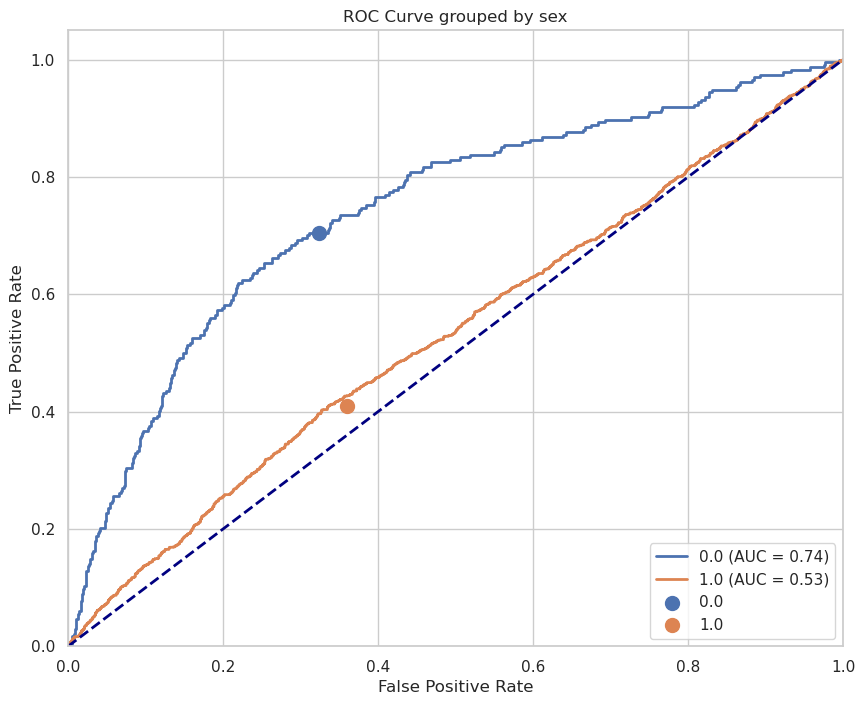

In [100]:
plot_roc_simple(distorted_labels_test, test_prob, test_a, y_pre_fair_test,
        sensitive_attribute_name = 'sex',
        )

In [101]:
# to_demograph = ThresholdOptimizer(
#     estimator=classifier_fake,
#     constraints='demographic_parity', # Independence
#     objective='balanced_accuracy_score',  
#     predict_method='predict_proba',
# )

# # fit ThresholdOptimizer
# to_demograph.fit(X_test_2D, distorted_labels_test, sensitive_features=a_test)

# # plot_threshold_optimizer
# plot_threshold_optimizer(to_demograph, ax=None, show_plot=True)

array([[<Axes: title={'center': 'accuracy'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'true_positive_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'true_negative_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'count'}, xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>]], dtype=object)

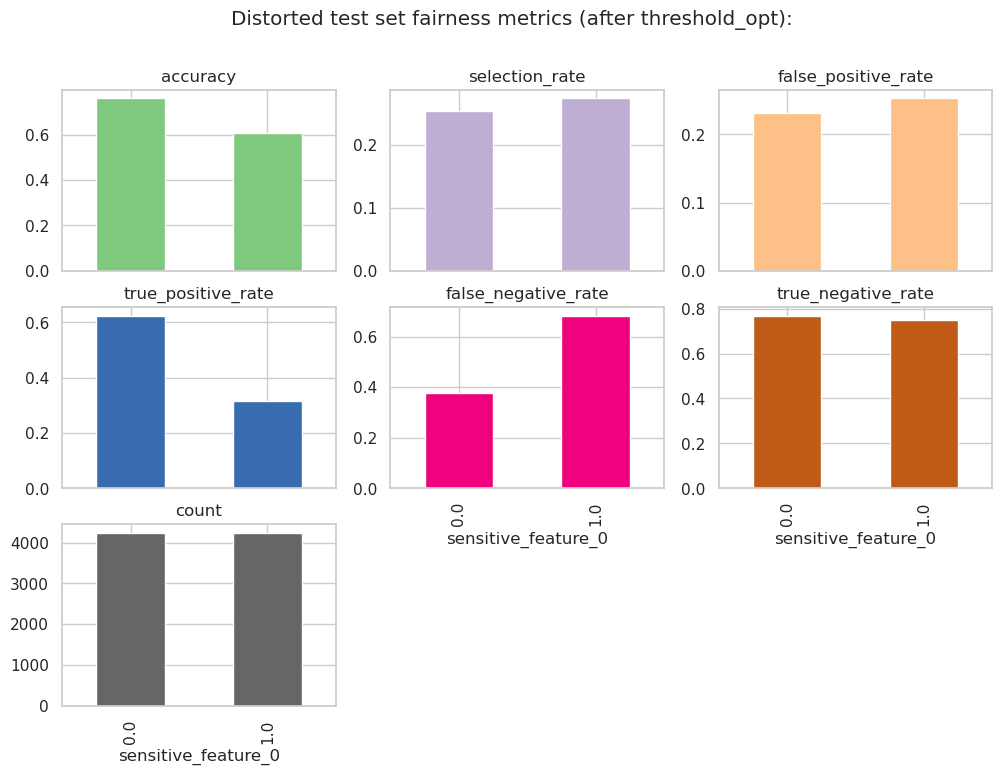

In [102]:
# y_distorted_pre_fair_test = to_demograph.predict(X_test_2D, sensitive_features=a_test)
mf_distorted_Independence = MetricFrame(metrics=metrics,
                 y_true=distorted_labels_test,
                 y_pred=y_pred_new_threshold_opt,
                 sensitive_features=a_test)
mf_distorted_Independence.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Distorted test set fairness metrics (after threshold_opt):",
)

In [103]:
df_distorted_test_to_independence = mf_distorted_Independence.by_group
print(f'df_distorted_test_to_independence:')
df_distorted_test_to_independence

df_distorted_test_to_independence:


,accuracy,selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
sensitive_feature_0,,,,,,,
0.0,0.760463,0.253251,0.231539,0.623932,0.376068,0.768461,4229.0
1.0,0.605674,0.273995,0.252732,0.317301,0.682699,0.747268,4230.0


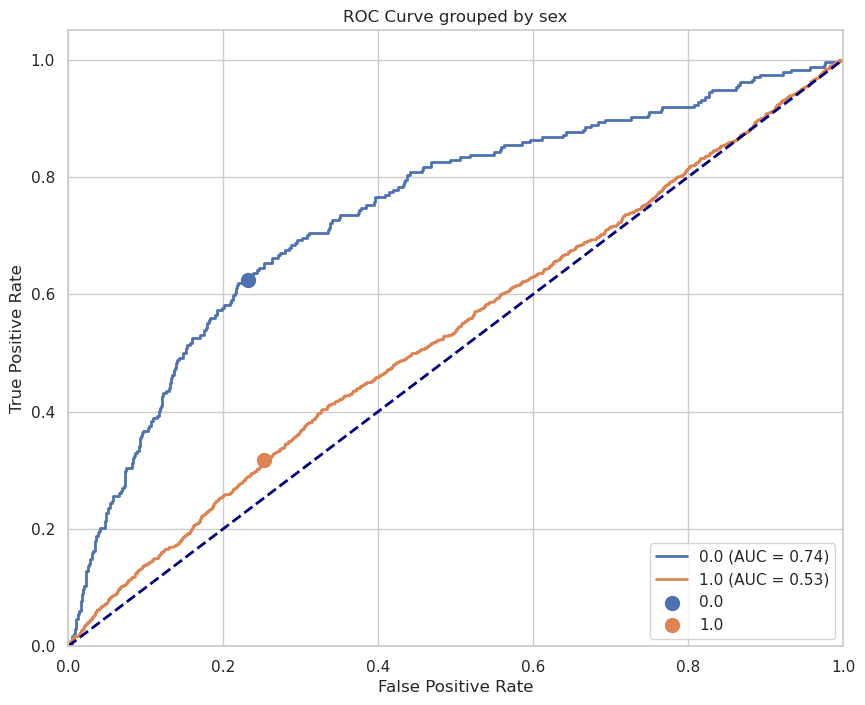

In [104]:
plot_roc_simple(distorted_labels_test, test_prob, test_a, y_pred_new_threshold_opt,
        sensitive_attribute_name = 'sex',
        )

## -----------------We also distort val dataset at this part-------------------------------------------------

In [115]:
## distort 10%
import numpy as np
# create a new set of distorted target labels
distorted_labels_val = y_val.clone()

# Get indices of male individuals (a_test == 1) with healthy labels (distorted_labels_test == 0)
male_indices_val = (a_val == 1) & (distorted_labels_val == 0)
print(f'a_test == 1.shape={np.where(a_val == 1)[0].shape}')
print(f'a_test.shape={a_val.shape}')
print(f'distorted_labels_test == 0.shape={np.where(distorted_labels_val==0)[0].shape}')
print(f'y_test.shape={y_test.shape}')
print(f'male_indices_test.shape={male_indices_val.shape}')
male_healthy_indices_val = np.where(male_indices_val)[0]
print(f'male_healthy_indices_test.shape ={male_healthy_indices_val.shape}')
# Determine the number of labels to flip (30% of healthy male labels)
# num_to_flip_val = int(0.1 * len(male_healthy_indices_val))
num_to_flip_val = int(0.3 * len(male_healthy_indices_val))

# Randomly select indices to flip
np.random.seed(42)  # For reproducibility
indices_to_flip_val = np.random.choice(male_healthy_indices_val, size=num_to_flip_val, replace=False)

# Flip the selected labels to diseased (label == 1)
distorted_labels_val[indices_to_flip_val] = 1

# Verify the changes
print(f"Original healthy male labels: {len(male_healthy_indices_val)}")
print(f"Number of labels flipped: {num_to_flip_val}")

a_test == 1.shape=(704,)
a_test.shape=torch.Size([1409])
distorted_labels_test == 0.shape=(1341,)
y_test.shape=torch.Size([8459])
male_indices_test.shape=torch.Size([1409])
male_healthy_indices_test.shape =(675,)
Original healthy male labels: 675
Number of labels flipped: 202


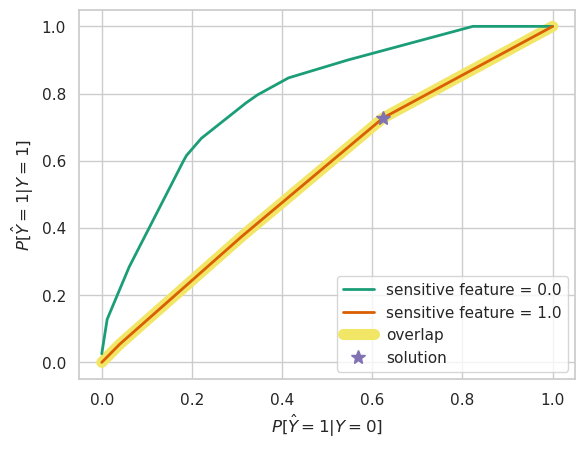

In [116]:
# define ThresholdOptimizer
to_distort_val_equalized_odds = ThresholdOptimizer(
    estimator=classifier_fake,
    constraints='equalized_odds', # TPR,FPR
    # constraints='demographic_parity', # Independence
    objective='balanced_accuracy_score',  
    predict_method='predict_proba',
)
# fit ThresholdOptimizer (with 10% distorted val)
to_distort_val_equalized_odds.fit(X_val_2D, distorted_labels_val, sensitive_features=a_val)

plot_threshold_optimizer(to_distort_val_equalized_odds, ax=None, show_plot=True)

/zhome/21/8/202236/miniconda3/envs/rai_fairness/lib/python3.9/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.75103582 0.51189833 0.75103582 ... 0.75103582 0.41141825 0.41141825]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


array([[<Axes: title={'center': 'accuracy'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'true_positive_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'true_negative_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'count'}, xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>]], dtype=object)

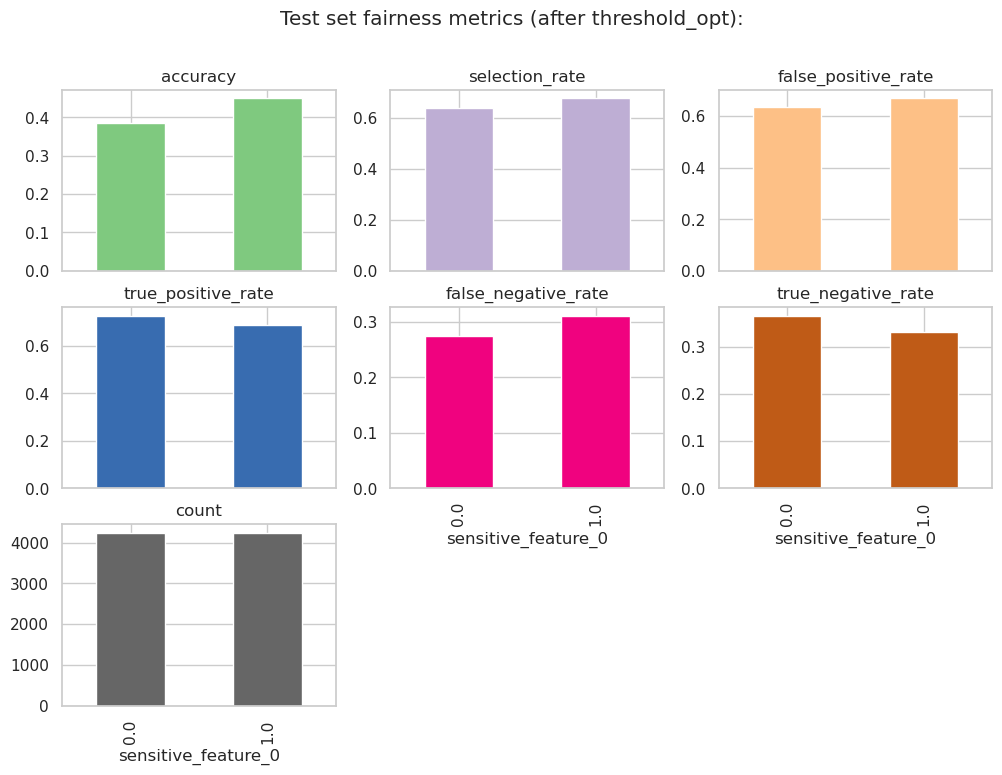

In [117]:
y_pre_fair_test_with_val_distorted = to_distort_val_equalized_odds.predict(X_test_2D, sensitive_features=a_test)

mf_with_val_distorted = MetricFrame(metrics=metrics,
                 y_true=distorted_labels_test,
                 y_pred=y_pre_fair_test_with_val_distorted,
                 sensitive_features=test_a)

mf_with_val_distorted.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Test set fairness metrics (after threshold_opt):",
)


In [118]:
df_distorted_val = mf_with_val_distorted.by_group
# print(f'10% val distorted with contraint = equalized_odd:')
# print(f'10% val distorted with contraint = Independence:')
print(f'30% val distorted with contraint = equalized_odd:')
# print(f'30% val distorted with contraint = Indenpendence:')
df_distorted_val

30% val distorted with contraint = equalized_odd:


,accuracy,selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
sensitive_feature_0,,,,,,,
0.0,0.385670,0.639395,0.634293,0.726496,0.273504,0.365707,4229.0
1.0,0.449173,0.675414,0.668664,0.689160,0.310840,0.331336,4230.0


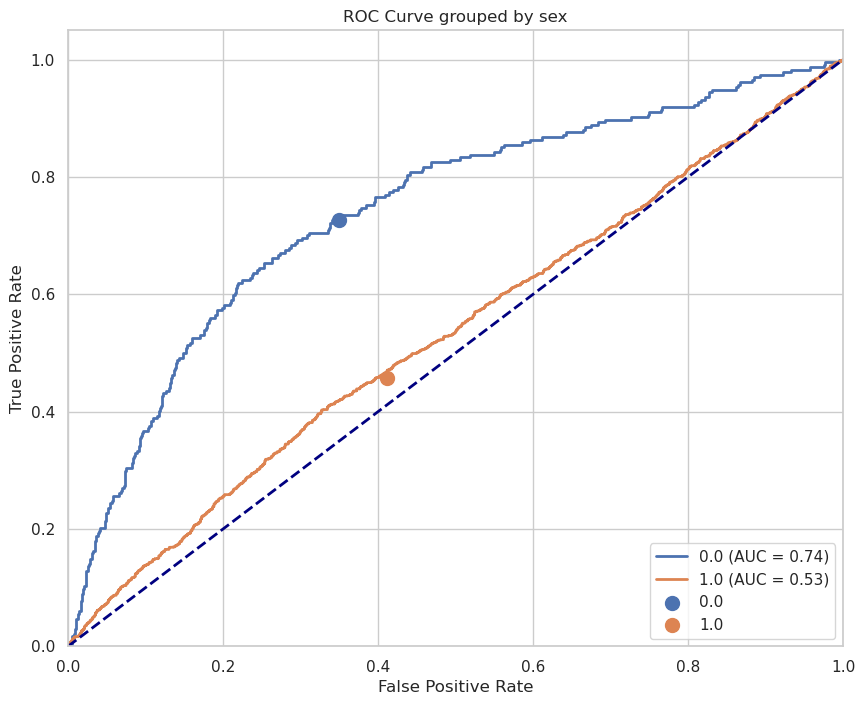

In [114]:
plot_roc_simple(distorted_labels_test, test_prob, test_a, y_pre_fair_test_with_val_distorted,
        sensitive_attribute_name = 'sex',
        )

In [110]:
import json
threshold_rules_by_group_distorted_val_set = to_distort_val_equalized_odds.interpolated_thresholder_.interpolation_dict
print(json.dumps(threshold_rules_by_group_distorted_val_set , default=str, indent=4))

{
    "0.0": {
        "p_ignore": 0.6093801911899192,
        "prediction_constant": 0.46900000000000003,
        "p0": 0.5553095238095237,
        "operation0": "[>0.19408950954675674]",
        "p1": 0.4446904761904763,
        "operation1": "[>0.11093277484178543]"
    },
    "1.0": {
        "p_ignore": 0.0,
        "prediction_constant": 0.46900000000000003,
        "p0": 0.9981463414634144,
        "operation0": "[>0.060312436893582344]",
        "p1": 0.0018536585365855895,
        "operation1": "[>0.042685629799962044]"
    }
}
